<a href="https://colab.research.google.com/github/urosgodnov/juypterNotebooks/blob/main/DataMining/Machine_Learning_with_Python_Applying_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recommended Pipeline Order**

To maintain a robust and leakage-free pipeline, follow this sequence:

- Data Importing and Splitting:

  - Separate X and y: Split your dataset into features (X) and target (y) before any transformations.

  - Train-Test Split: Divide the data into training and testing sets to prevent data leakage.

- Pipeline Steps on Training Data:

  - Preprocessing:
   - Handle Missing Values: Impute or remove missing data.
   - Encode Categorical Variables: Apply encoding techniques like OrdinalEncoder or OneHotEncoder.
   - Scaling/Standardization: Use StandardScaler or similar to normalize numerical features.

  - Balancing:
   - Resampling Techniques: Apply methods like SMOTE, RandomOverSampler, or RandomUnderSampler to balance classes.

- Feature Selection:
  - Variance Thresholding: Remove low-variance features.
SelectKBest / RFE: Select top features based on statistical tests or model-based importance.

- Model Training:
  - Classifier: Train your classification model (e.g., Logistic Regression, Random Forest).

- Testing Data:

Apply the same preprocessing steps (without balancing) to the test set.
Evaluate the model's performance on the test data.

# Applying algorithm - regression

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import re
from imblearn.pipeline import Pipeline as ImbPipeline

In [10]:
def clean_names(df):
    # Function to clean individual column names
    def clean_column_name(name):
        name = name.strip()  # Remove leading and trailing spaces
        name = name.lower()  # Convert to lowercase
        name = re.sub(r'[^\w\s]', '', name)  # Remove special characters except for underscores and alphanumeric
        name = re.sub(r'\s+', '_', name)  # Replace spaces with underscores
        return name

    # Apply the cleaning function to all column names
    df.columns = [clean_column_name(col) for col in df.columns]
    return df

In [74]:
def replace_infrequent_categories(X, threshold=40):
    X = X.copy()  # Avoid modifying the original DataFrame

    # Select categorical columns (object or category dtype)
    categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

    for col in categorical_cols:
        # Count frequencies including NaN
        counts = X[col].value_counts(dropna=False)

        # Identify categories to keep (frequency > threshold or NaN)
        frequent_categories = counts[counts > threshold].index.tolist()

        # Replace infrequent categories with 'Other'
        X[col] = X[col].apply(
            lambda x: x if (pd.isnull(x) or x in frequent_categories) else "Other"
        )

    return X

In [73]:
def remove_outliers(df, cols, threshold=3):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            z_scores = (df[col] - df[col].mean()) / df[col].std()
            df = df[(z_scores.abs() <= threshold)]
    return df

In [64]:
df=pd.read_csv("https://raw.githubusercontent.com/urosgodnov/datasets/refs/heads/master/laptip_prices_without_missing_values.csv")

df=clean_names(df)

df.head()

,company,product,typename,inches,screenresolution,cpu_company,cpu_type,cpu_frequency_ghz,ram_gb,memory,gpu_company,gpu_type,opsys,weight_kg,price_euro
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8.0,128GB SSD,Intel,Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8.0,128GB Flash Storage,Intel,HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,2.5,8.0,256GB SSD,Intel,HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16.0,512GB SSD,AMD,Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8.0,256GB SSD,Intel,Iris Plus Graphics 650,macOS,1.37,1803.60


**Spliting columns**

In [65]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove outliers from numerical columns
df = remove_outliers(df, numerical_cols + ['price_euro'])

# independent and dependent variables
X = df.drop('price_euro', axis=1)
y = df['price_euro']

## Training and testing dataset with standardization

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [67]:
# Wrap the custom function using FunctionTransformer
frequency_transformer = FunctionTransformer(
    replace_infrequent_categories,
    kw_args={'threshold': 40},  # Pass additional arguments if needed
    validate=False               # Allows the transformer to accept pandas DataFrame
)

In [100]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),                # Scale numerical features
        ('cat', OrdinalEncoder(), categorical_cols)  # Encode categorical features
    ],
    remainder='passthrough'  # Keep other columns unchanged
)

## Linear regression

In [69]:
pipeline = ImbPipeline(steps=[
    ('frequency_transformer', frequency_transformer),        # Custom frequency encoding
    ('preprocessor', preprocessor),                          # Preprocessing step
    ('feature_selection', SelectKBest(score_func=f_regression, k=5)),  # Feature selection step
    ('regression', LinearRegression())                       # Regression model
])

In [70]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the training and testing data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

**Accessing a step in pipeline**

e.g. after function

In [ ]:
frequency_transformer = pipeline.named_steps['frequency_transformer']

# Transform the training data (e.g., after preprocessing)
X_train_transformed = frequency_transformer.transform(X_train)

# Convert to DataFrame for better readability (if necessary)
pd.DataFrame(X_train_transformed).head()

### Metric - how good is our model

In [71]:
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})
comparison_df.head()

,Actual,Predicted
559,617.9,470.109853
268,1018.0,966.865009
43,682.0,787.483368
1051,979.0,1272.842842
607,564.0,975.370116


In [72]:
# Evaluate on testing data
print("\nTesting Metrics:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred))
print("R^2 Score:", r2_score(y_test, y_test_pred))


Testing Metrics:
Mean Squared Error (MSE): 144689.21103364823
Mean Absolute Error (MAE): 303.9307350266816
R^2 Score: 0.5536479273851538


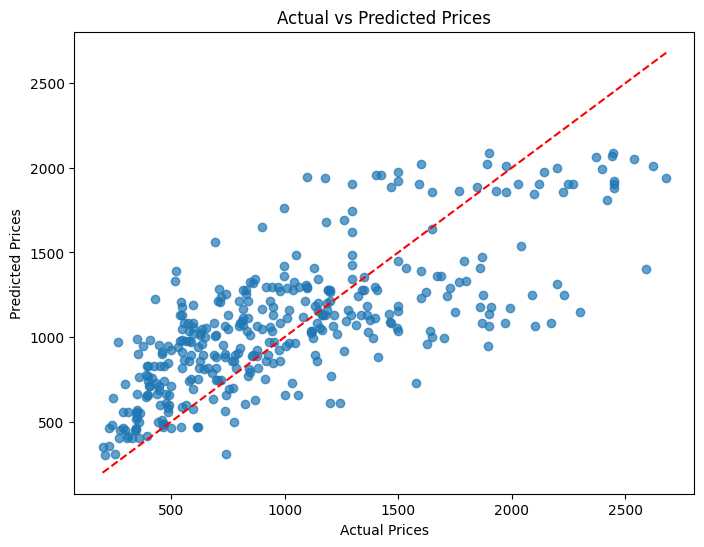

In [75]:
# Plot predicted vs actual values for testing data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

## AdaBoost regression

In [39]:
from sklearn.ensemble import AdaBoostRegressor

In [76]:
pipeline = ImbPipeline(steps=[
    ('frequency_transformer', frequency_transformer),        # Custom frequency encoding
    ('preprocessor', preprocessor),                          # Preprocessing step
    ('feature_selection', SelectKBest(score_func=f_regression, k=3)),  # Feature selection step
    ('regression', AdaBoostRegressor(estimator=LinearRegression(), n_estimators=1000, learning_rate=1.0))                       # Regression model
])

In [77]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the training and testing data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

**Showing the original and predicted value**

In [78]:
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})
comparison_df.head()

,Actual,Predicted
559,617.9,570.566348
268,1018.0,947.713343
43,682.0,756.415440
1051,979.0,1363.636608
607,564.0,1005.951014


### Metric - how good is our model

In [79]:
print("\nTesting Metrics:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred))
print("R^2 Score:", r2_score(y_test, y_test_pred))


Testing Metrics:
Mean Squared Error (MSE): 147534.49271883714
Mean Absolute Error (MAE): 308.0175976718574
R^2 Score: 0.5448705115136843


**Model vizualization**

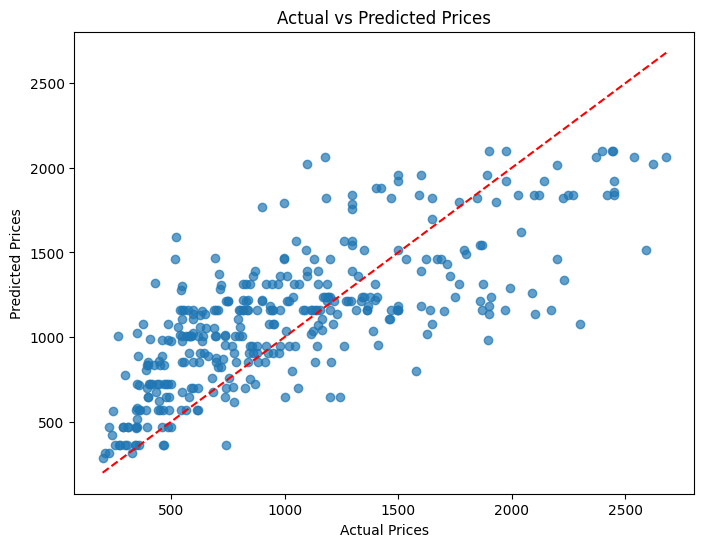

In [80]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

## XGBoost Linear Regression

In [94]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

In [110]:
param_grid = {
    'alpha': [0.01, 0.05, 0.5, 1.0],          # L1 regularization
    'lambda_': [0.1, 0.5, 1.0],              # L2 regularization
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300, 400],     # Number of boosting rounds
    'lambda_bias': [0.01, 0.1, 0.5, 1.0]      # L2 regularization for the bias term
}

model = XGBRegressor(booster='gblinear', objective='reg:squarederror')

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)


pipeline = ImbPipeline(steps=[
    ('frequency_transformer', frequency_transformer),                   # Custom frequency encoding (placeholder)
    ('preprocessor', preprocessor),                                     # Preprocessing step (placeholder)
    ('feature_selection', SelectKBest(score_func=f_regression, k=5)),   # Feature selection step
    ('regression', grid_search)                                         # Regression model w/ hyperparam search
])


In [ ]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the training and testing data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


In [ ]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Access the best model
best_model = grid_search.best_estimator_



Best parameters found:  {'alpha': 0.01, 'lambda_': 0.5, 'lambda_bias': 0.01, 'learning_rate': 0.01, 'n_estimators': 300}
Best cross-validation score:  -0.2913979231452525


**Showing the original and predicted value**

In [ ]:
# Make predictions on the test data
y_pred_scaled = best_model.predict(X_test_encode_final)

# If you've scaled your target variable (y), you need to inverse transform it back to the original scale
# Assuming you used a StandardScaler or similar to scale y, inverse transform both y_test_scaled and y_pred_scaled.
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))  # Inverse transform the predictions
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))  # Inverse transform the actual values

results_df = pd.DataFrame({'y_test_original': y_test_original.flatten(), 'y_pred_original': y_pred_original.flatten()})

results_df.head(10)

,y_test_original,y_pred_original
0,650.00,606.421
1,716.00,857.817
2,1584.00,1484.395
3,1020.00,854.431
4,1749.00,1072.783
5,557.37,934.606
6,999.00,1168.441
7,330.00,507.134
8,2267.86,2073.004
9,682.00,572.801


### Metric - how good is our model

In [ ]:
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# Create a dictionary of the results
results_dict = {'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'R-squared': [r2]}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)
print(results_df)

       MAE         MSE     RMSE  R-squared
0  250.554  134963.092  367.373      0.737


**Model vizualization**

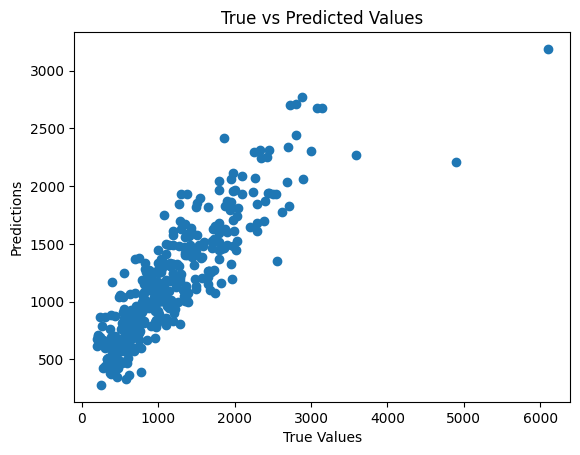

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test_original, y_pred_original)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

## Summary

- Linear Regression: Best for simple linear problems, fast and easy to interpret, but limited to linearly separable data.
- AdaBoost Regression: More powerful than Linear Regression by focusing on hard-to-predict samples, handles both linear and non-linear relationships, but can be sensitive to outliers and overfitting.
- XGBoost Regression: A state-of-the-art model for complex problems, very flexible, handles non-linear data extremely well, and is great for large datasets, but requires careful tuning.

Each model has its own strengths depending on the nature of the problem.
If you have simple, linear data, Linear Regression works well. For more complex datasets, AdaBoost and XGBoost can yield better performance, with XGBoost being particularly powerful for large datasets and non-linear relationships.

# Applying algorithm - clasification

## Logistic regression

In [ ]:
# Import necessary libraries
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the Breast Cancer dataset
data = load_breast_cancer()

# Convert the dataset into a Pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target (0: malignant, 1: benign) to the DataFrame
df['target'] = data.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,...,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.118,...,0.712,0.265,0.460,0.119,0
1,20.57,17.77,132.90,1326.0,0.085,...,0.242,0.186,0.275,0.089,0
2,19.69,21.25,130.00,1203.0,0.110,...,0.450,0.243,0.361,0.088,0
3,11.42,20.38,77.58,386.1,0.142,...,0.687,0.258,0.664,0.173,0
4,20.29,14.34,135.10,1297.0,0.100,...,0.400,0.163,0.236,0.077,0


### Basic data overview

In [ ]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,...,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000
mean,14.127,19.290,91.969,654.889,0.096,...,0.272,0.115,0.290,0.084,0.627
std,3.524,4.301,24.299,351.914,0.014,...,0.209,0.066,0.062,0.018,0.484
min,6.981,9.710,43.790,143.500,0.053,...,0.000,0.000,0.157,0.055,0.000
25%,11.700,16.170,75.170,420.300,0.086,...,0.115,0.065,0.250,0.071,0.000
50%,13.370,18.840,86.240,551.100,0.096,...,0.227,0.100,0.282,0.080,1.000
75%,15.780,21.800,104.100,782.700,0.105,...,0.383,0.161,0.318,0.092,1.000
max,28.110,39.280,188.500,2501.000,0.163,...,1.252,0.291,0.664,0.207,1.000


**Distribution of target variable**

<Axes: xlabel='target'>

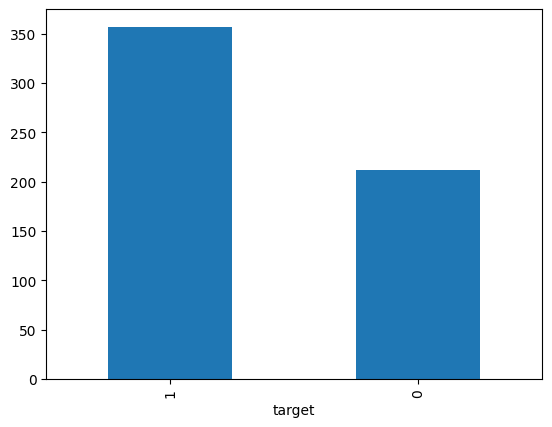

In [ ]:
df['target'].value_counts().plot.bar()

The bar chart you've provided shows a **class imbalance** in the target variable, where one class (labeled as 1) has significantly more samples than the other class (labeled as 0).

This type of imbalance can negatively impact machine learning models, especially classification models, because the model may be biased toward predicting the majority class.

**Correlation matrix**

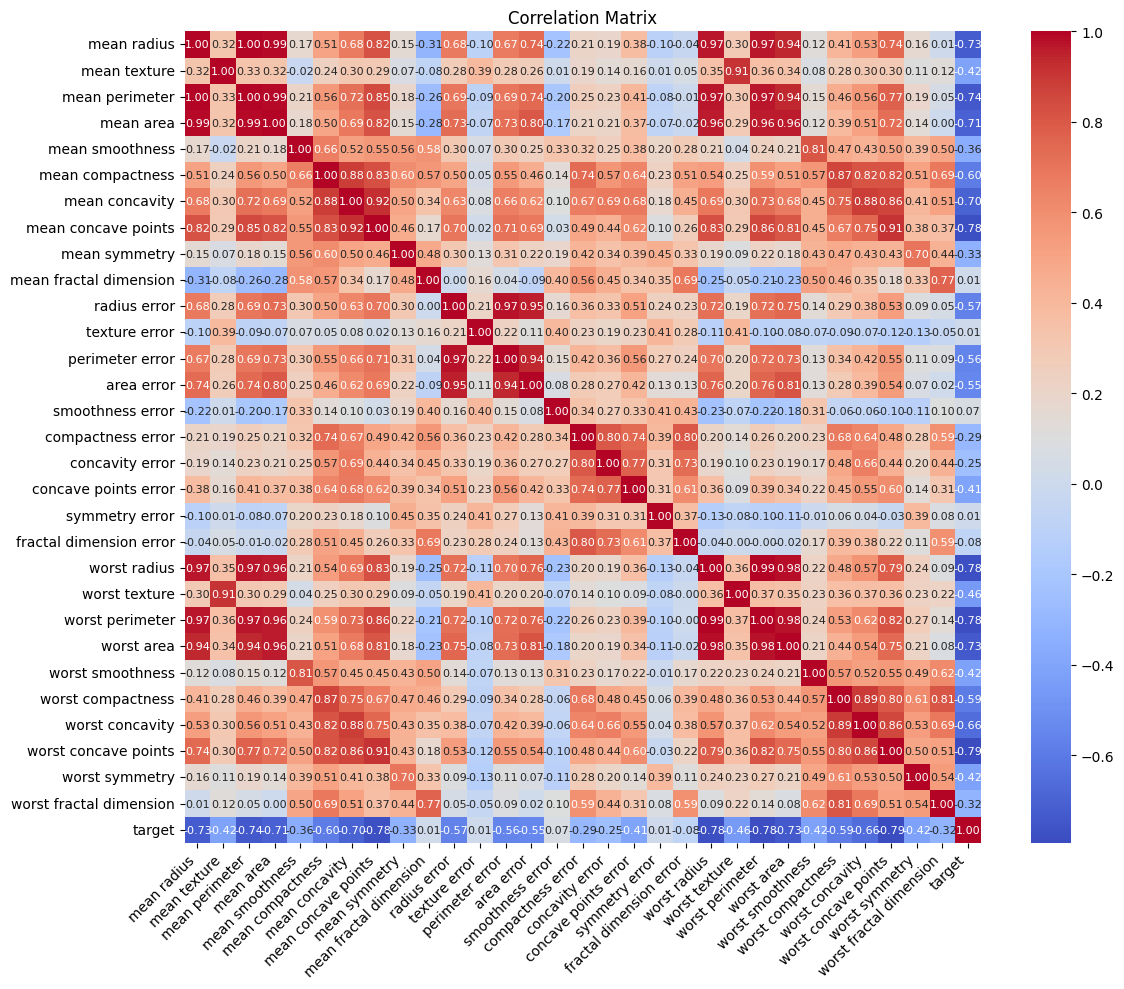

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plotting the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})
# Reduced font size for annotations
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0) # Rotate y-axis labels
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

**How serious is the multicollinearity**

In [ ]:
features=df.columns.to_list()
features.remove('target')
features

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
    return vif_data

   # Example usage (assuming 'df' is your DataFrame and 'features' is a list of your feature columns)
features = features  # Replace with your actual feature columns
vif_df = calculate_vif(df, features)
print(vif_df)

                    feature        VIF
0               mean radius  63306.172
1              mean texture    251.047
2            mean perimeter  58123.586
3                 mean area   1287.262
4           mean smoothness    393.398
..                      ...        ...
25        worst compactness    132.884
26          worst concavity     86.310
27     worst concave points    148.673
28           worst symmetry    218.920
29  worst fractal dimension    423.397

[30 rows x 2 columns]


### Dimension reduction with Lasso and VIF

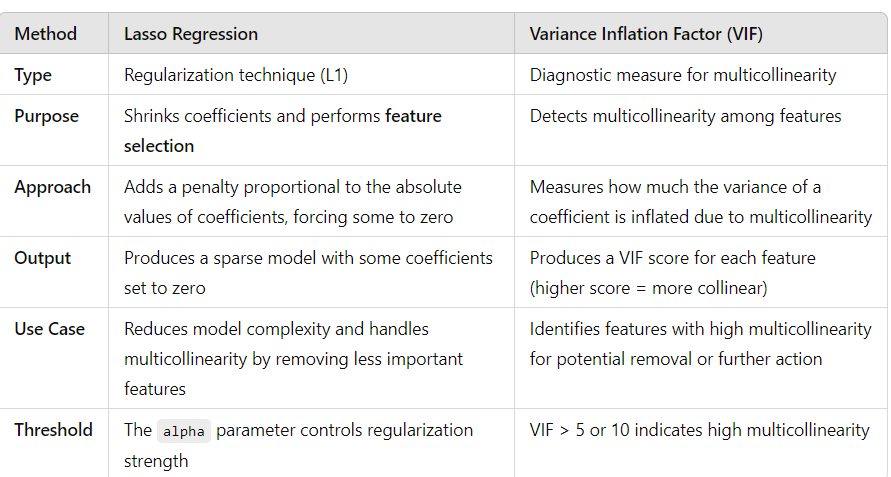

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [ ]:
# X = Features, y = Target
X = df.drop(columns=['target'])  # Features (dropping the target)
y = df['target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (Lasso prefers normalized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

# The best alpha value found by cross-validation
print(f"Best alpha: {lasso_cv.alpha_}")

# Fit Lasso with the best alpha
lasso_best = Lasso(alpha=lasso_cv.alpha_)
lasso_best.fit(X_train_scaled, y_train)

# Get the coefficients of the selected features
lasso_best_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_best.coef_
})

# Keep only the features with non-zero coefficients
selected_features = lasso_best_coef[lasso_best_coef['Coefficient'] != 0]

**Selected features**

In [ ]:
lasso_best_coef

,Feature,Coefficient
0,mean radius,-0.000
1,mean texture,0.003
2,mean perimeter,-0.000
3,mean area,0.000
4,mean smoothness,-0.014
...,...,...
25,worst compactness,-0.061
26,worst concavity,-0.165
27,worst concave points,0.064
28,worst symmetry,-0.061


In [ ]:
selected_features.Feature.to_list()

['mean texture',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'worst radius',
 'worst texture',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [ ]:
features = selected_features.Feature.to_list()
vif_df = calculate_vif(df, features)
print(vif_df)

                    feature      VIF
0              mean texture  238.222
1           mean smoothness  346.001
2          mean compactness  105.143
3            mean concavity  142.520
4       mean concave points  134.789
..                      ...      ...
19        worst compactness   98.859
20          worst concavity   78.762
21     worst concave points  139.171
22           worst symmetry  207.828
23  worst fractal dimension  101.908

[24 rows x 2 columns]


In [ ]:
features=selected_features.Feature.to_list()
features.remove('mean smoothness')
features.remove('mean texture')
features.remove('mean symmetry')
features.remove('mean concavity')
features.remove('worst radius')
features.remove('worst smoothness')
features.remove('worst concave points')
features.remove('radius error')
features.remove('worst compactness')
features.remove('worst symmetry')
features.remove('mean compactness')
features.remove('perimeter error')
features.remove('worst texture')
features.remove('worst fractal dimension')
features.remove('concave points error')
features.remove('worst area')
features.remove('mean concave points')
features.remove('compactness error')
features.remove('symmetry error')
# Recalculate VIF after dropping the feature
vif_reduced = calculate_vif(df, features)
vif_reduced

,feature,VIF
0,texture error,5.708
1,area error,2.157
2,smoothness error,6.006
3,concavity error,4.236
4,worst concavity,4.558


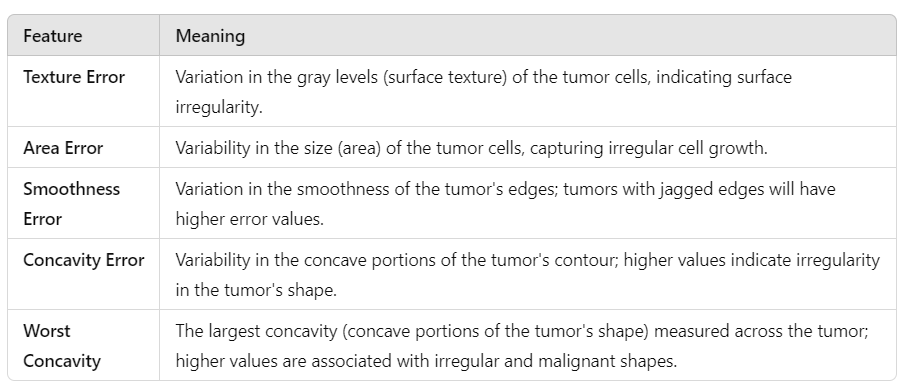

**Rechecking correlation matrix**

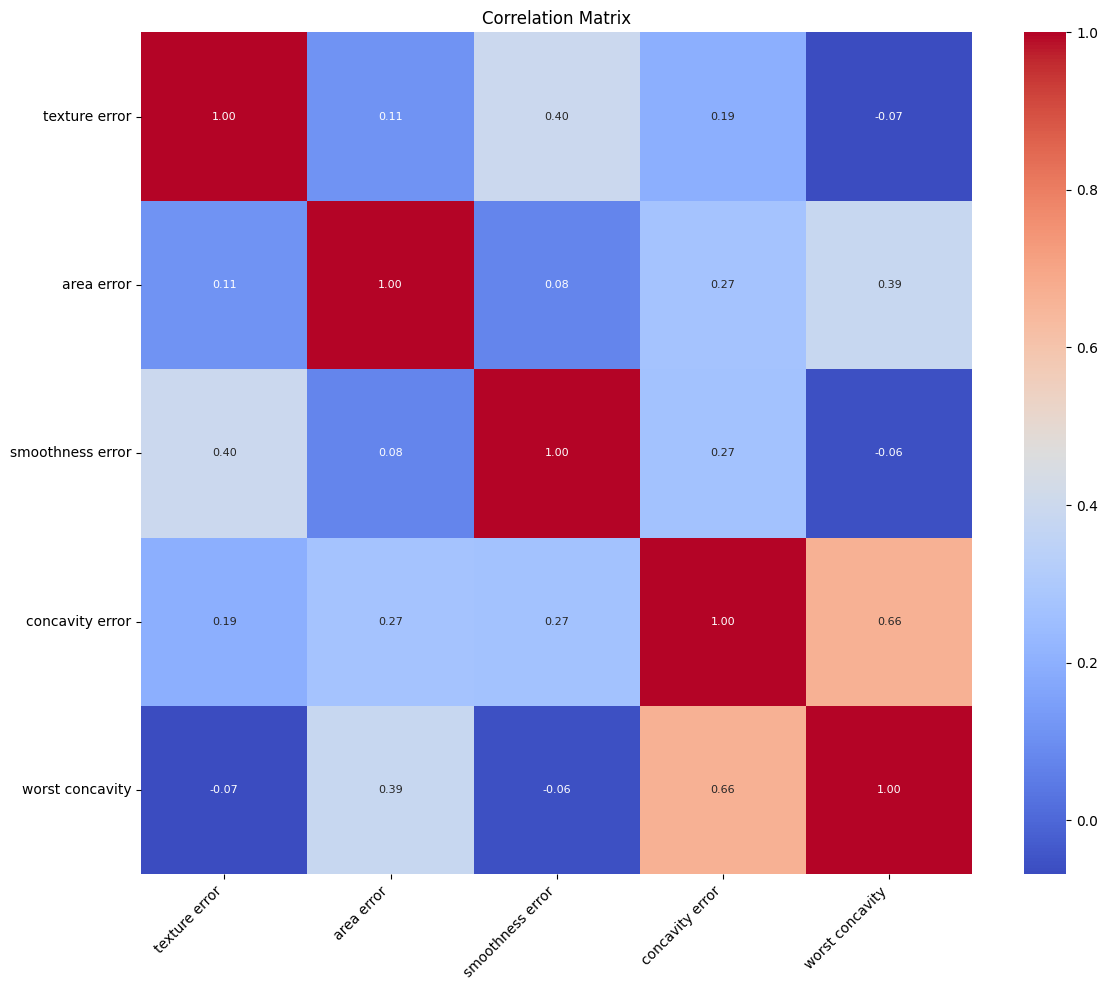

In [ ]:
# Plotting the correlation matrix using seaborn heatmap

corr_matrix = df[features].corr()
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})
# Reduced font size for annotations
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0) # Rotate y-axis labels
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

**Applying model**

In [ ]:
features.append('target')
df=df[features]
df.head()

,texture error,area error,smoothness error,concavity error,worst concavity,target
0,0.905,153.40,0.006,0.054,0.712,0
1,0.734,74.08,0.005,0.019,0.242,0
2,0.787,94.03,0.006,0.038,0.450,0
3,1.156,27.23,0.009,0.057,0.687,0
4,0.781,94.44,0.011,0.057,0.400,0


In [ ]:
# Convert to feature matrix (X) and target vector (y)
X = df.drop('target', axis=1)
y = df.target

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature data (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model to the training data
log_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test_scaled)

In [ ]:
results_df = pd.DataFrame({'y_original': y_test, 'y_prediction': y_pred})

results_df.head(10)

,y_original,y_prediction
204,1,1
70,0,0
131,0,0
431,1,1
540,1,1
567,0,0
369,0,0
29,0,0
81,1,0
477,1,1


### How good is our model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


**Confusion matrix**

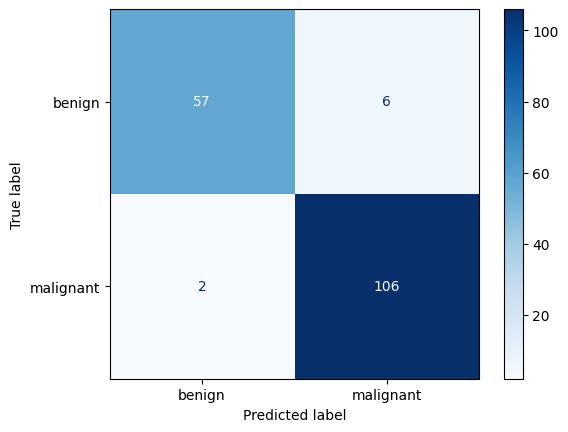

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['benign','malignant'])
disp.plot(cmap="Blues")

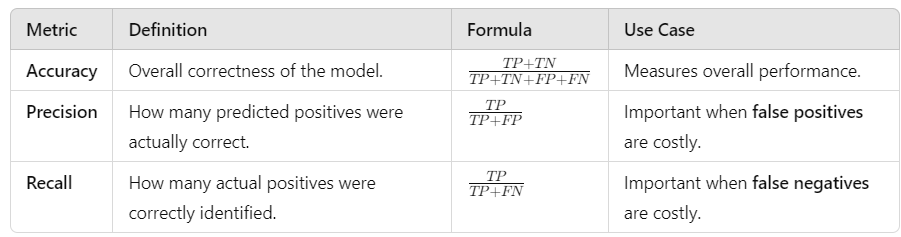

In [ ]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.95
Recall: 0.98
F1-score: 0.96


- Accuracy: The percentage of correctly classified samples. In this case, the model's accuracy is 97%.

- Precision: When the model predicted a tumor as malignant, it was correct 95% of the time. This is a good sign, as the model makes few false-positive predictions (predicting benign tumors as malignant)..

- Recall: The model correctly identified 98% of the actual malignant tumors. This is an excellent recall, indicating that the model is very good at identifying malignant tumors and rarely misses them (few false negatives).

- F1-Score: The harmonic mean of precision and recall, providing a balance between the two metrics. The F1-score of 0.97 suggests that the model achieves a good balance between precision and recall.

**ROC**

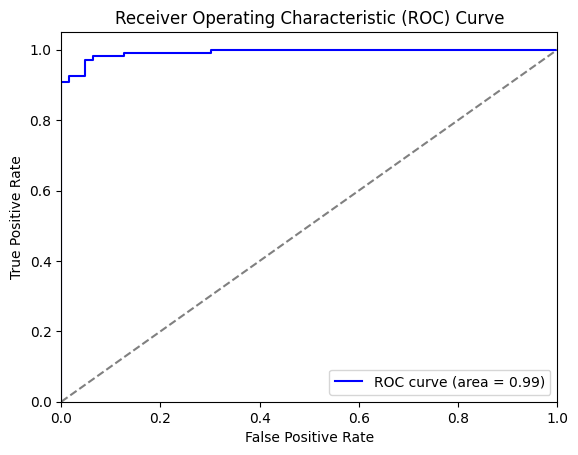

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Decision trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# Fit the Decision Tree Classifier on the training data
tree_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = tree_clf.predict(X_test)

results_df = pd.DataFrame({'y_original': y_test, 'y_prediction': y_pred})

results_df.head(10)


,y_original,y_prediction
204,1,0
70,0,0
131,0,0
431,1,1
540,1,1
567,0,0
369,0,0
29,0,0
81,1,0
477,1,1


### How good is our model

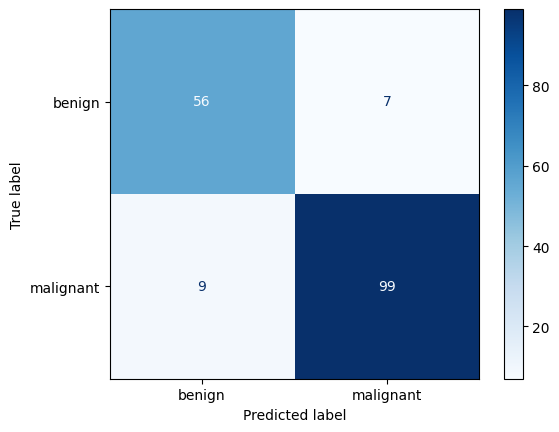

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['benign','malignant'])
disp.plot(cmap="Blues")

**Feature importance**

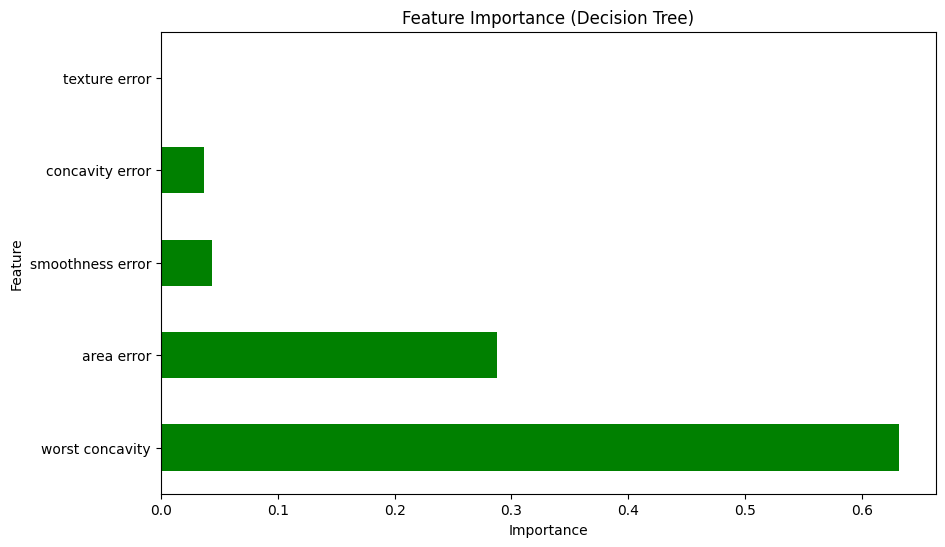

In [ ]:
# Get feature importance from the Decision Tree model
feature_importance = pd.Series(tree_clf.feature_importances_, index=df.columns.drop("target"))

# Plot the feature importance as a bar chart
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='barh', color='green')
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.91
Precision: 0.93
Recall: 0.92
F1-score: 0.93


- Accuracy (0.91): The model correctly classified 91% of all instances.

- Precision (0.93): When the model predicted a tumor as malignant, it was correct 93% of the time.

- Recall (0.92): The model correctly identified 92% of actual malignant tumors.

- F1-score (0.93): The balance between precision and recall is very strong, indicating a good trade-off between the two.